In [3]:
#  /Data/celebs-usa/female contains 381 texts by females
#  /Data/celebs-usa/male contains 912 texts by males
#  /Data/celebs-other-json contains text by

# Identify birth year as that is a constant, these tweets are from 2011-2018, age range constantly changes but birth year stays constant
# using birth year, predict age 10-15, 15-20, 20-25, 25-30, 30-35, 35-40, 45-55,55+  
#{'25-34', '35-44', '45-54', '55-64', '65+'}

from os import listdir, makedirs
from os.path import isfile, join, splitext, split
import json
from collections import Counter
import ftfy
import re
import nltk

def import_celebs_json(folder):
    jsonfiles = [join(folder, f) for f in listdir(folder) if isfile(join(folder, f)) and f.endswith(".json")]
    for jf in jsonfiles:
        with open(jf) as f:
            data = json.load(f)
            handle = data['handle']
            gender = data['gender']
            age_range = data['age_range']
            english = data['english']
            year_of_birth = data['year_of_birth']
            #if ( (data['gender'] != 'unknown') and (data['year_of_birth'] != 'unknown')):
            print("Processing " + handle)
            doc = Document({'handle': handle, 'gender': gender, 'year_of_birth':year_of_birth, 'age_range': age_range, 'english': english}) #include metadata
            for tweet in data['tweets']:
                doc.extract_features_from_text(tweet['text'])
            yield doc
            
        
hashtag_re = re.compile(r"#\w+")
mention_re = re.compile(r"@\w+")
url_re = re.compile(r"(?:https?://)?(?:[-\w]+\.)+[a-zA-Z]{2,9}[-\w/#~:;.?+=&%@~]*")

def preprocess(text):
    p_text = hashtag_re.sub("[hashtag]",text)
    p_text = mention_re.sub("[mention]",p_text)
    p_text = url_re.sub("[url]",p_text)
    p_text = ftfy.fix_text(p_text)
    return p_text.lower()

tokenise_re = re.compile(r"(\[[^\]]+\]|[-'\w]+|[^\s\w\[']+)") #([]|words|other non-space)
def tokenise(text):
    return tokenise_re.findall(text)

        
class Document:
    def __init__(self, meta={}):
        self.meta = meta
        self.tokens_fql = Counter() #empty Counter, ready to be added to with Counter.update.
        self.pos_fql = Counter()
        self.pos_list = [] #empty list for pos tags from running text.
        self.num_tokens = 0
        
    def extract_features_from_text(self, text):
        p_text = preprocess(text)
        tokens = tokenise(p_text)
        self.num_tokens += len(tokens)
        self.tokens_fql.update(tokens) #updating Counter counts items in list, adding to existing Counter items.
        pos_tagged = nltk.pos_tag(tokens)
        pos = [tag[1] for tag in pos_tagged]
        self.pos_fql.update(pos)
        self.pos_list.extend(pos)
        
    def extract_features_from_texts(self, texts): #texts should be iterable text lines, e.g. read in from file.
        for text in texts:
            extract_features_from_text(text)
            
    def average_token_length(self):
        sum_lengths = 0
        for key, value in self.tokens_fql.items():
            sum_lengths += len(key) * value
        return sum_lengths / self.num_tokens

In [4]:
'''
# Reading Male and Female Data First
from os import listdir
from os.path import isfile, join, splitext, split

def list_files(folder):
    textfiles = [join(folder, f) for f in listdir(folder) if isfile(join(folder, f)) and f.endswith(".txt")]
    return textfiles
'''

'\n# Reading Male and Female Data First\nfrom os import listdir\nfrom os.path import isfile, join, splitext, split\n\ndef list_files(folder):\n    textfiles = [join(folder, f) for f in listdir(folder) if isfile(join(folder, f)) and f.endswith(".txt")]\n    return textfiles\n'

In [5]:
# Try and open existing pickle file, if not exists then create new pickle file
import pickle
import os

corpus = []
'''
try:
    foo = pickle.load(open("/Data/CelebFile", "rb"))
except as e:
    corpus.extend(import_celebs_json("/home/jay/Documents/AppliedDataMining/FinalProject/Data/celebs-json"))
    with open('/Data/CelebFile', 'wb') as fp:
        pickle.dump(corpus, fp)

'''

if os.path.exists("/home/jay/Documents/AppliedDataMining/FinalProject/Data/CelebFile"):
    with open('/home/jay/Documents/AppliedDataMining/FinalProject/Data/CelebFile', 'rb') as fp:
        corpus = pickle.load(fp)
else:
    corpus.extend(import_celebs_json("/home/jay/Documents/AppliedDataMining/FinalProject/Data/celebs-json"))
    with open('/home/jay/Documents/AppliedDataMining/FinalProject/Data/CelebFile', 'wb') as fp:
        pickle.dump(corpus, fp)
    


In [6]:
from collections import Counter



genderCorpus = [d for d in corpus if d.meta['gender'] != 'unknown']
gender_y = [d.meta['gender'] for d in genderCorpus]
gender_X = genderCorpus
GenderCount = Counter(gender_y)

birthCorpus = [d for d in corpus if d.meta['year_of_birth'] != 'unknown']
birth_year_y = [d.meta['year_of_birth'] for d in birthCorpus]
birth_year_X = corpus
BirthYearCount = Counter(birth_year_y)

print(GenderCount)
print('---------------')
print(BirthYearCount)


Counter({'male': 203, 'female': 76})
---------------
Counter({1973: 17, 1986: 17, 1988: 14, 1985: 13, 1976: 10, 1980: 9, 1983: 9, 1984: 8, 1965: 8, 1982: 8, 1963: 7, 1970: 7, 1981: 7, 1977: 6, 1989: 6, 1978: 6, 1975: 6, 1962: 6, 1967: 6, 1966: 6, 1972: 6, 1958: 5, 1987: 5, 1957: 5, 1990: 5, 1971: 5, 1979: 5, 1951: 4, 1956: 4, 1992: 4, 1968: 4, 1974: 3, 1954: 3, 1955: 3, 1991: 3, 1950: 3, 1969: 3, 1993: 2, 1960: 2, 1959: 2, 1964: 2, 1941: 2, 1932: 1, 1935: 1, 1948: 1, 1953: 1, 1943: 1, 1952: 1, 1947: 1, 1939: 1, 1937: 1, 1942: 1, 1946: 1})


In [7]:
min(birth_year_y)  #1932
max(birth_year_y)  #1993


def getYearRange(yearOfBirth):
    YearGroupGap = 5
    for minYear in range(1930,2000,YearGroupGap):
        maxYear = minYear+YearGroupGap
        #print('min:', minYear)    
        #print('max:', maxYear)
        if (yearOfBirth >= minYear) and (yearOfBirth <= maxYear):
            return( str(minYear)+'-'+str(maxYear) )
    raise Exception('year of Birth passed in - ' +str(yearOfBirth)+' is not in range of min and max years' ) 
    
for doc in birthCorpus:
    if doc.meta['year_of_birth'] != 'unknown':
        birthYearRange = getYearRange(doc.meta['year_of_birth'])
        doc.meta['birth_year_range'] = birthYearRange

print('done')
    
    

done


In [8]:
birth_year_y = [d.meta['birth_year_range'] for d in birthCorpus]

In [9]:
Counter(birth_year_y)



Counter({'1930-1935': 2,
         '1990-1995': 9,
         '1950-1955': 12,
         '1975-1980': 36,
         '1970-1975': 37,
         '1980-1985': 45,
         '1955-1960': 18,
         '1985-1990': 47,
         '1945-1950': 6,
         '1960-1965': 23,
         '1965-1970': 26,
         '1940-1945': 4,
         '1935-1940': 2})

/home/jay/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


,Year,Frequency of people born
0,1932,1
11,1935,1
49,1937,1
48,1939,1
52,1941,2
50,1942,1
38,1943,1
51,1946,1
47,1947,1
15,1948,1


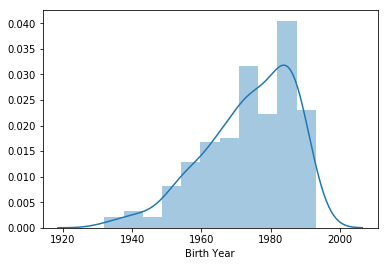

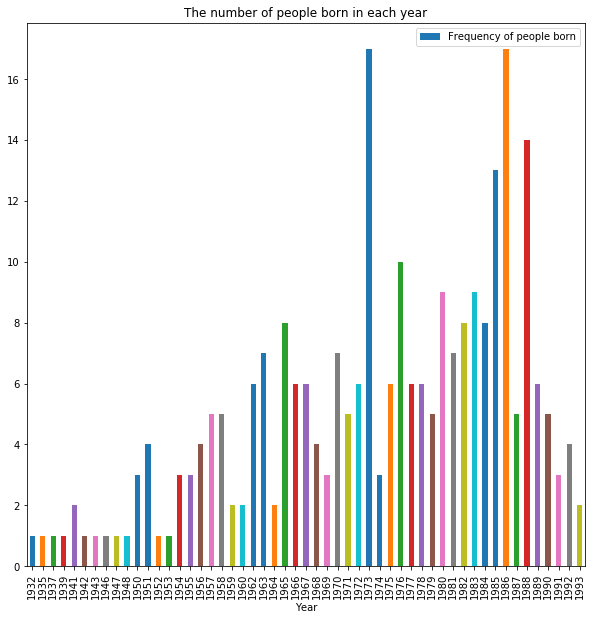

In [18]:
import seaborn as sns
import pandas as pd
import numpy as np
birth_year_y = [d.meta['year_of_birth'] for d in birthCorpus]

x = pd.Series(birth_year_y, name="Birth Year")

sns.distplot(x)


#df = pd.DataFrame(Counter(birth_year_y))

df = pd.DataFrame.from_dict(Counter(birth_year_y), orient='index').reset_index()

df.columns = ['Year','Frequency of people born']
df = df.sort_values(by=['Year'])

df.plot.bar(x='Year', y='Frequency of people born', rot=90,figsize=(10,10), title='The number of people born in each year')


df

In [129]:
import ndjson

def getCelebData():
    path = '/home/jay/Downloads/pan19-celebrity-profiling-training-dataset-2019-01-31/feeds.ndjson'
    path2 = '/home/jay/Downloads/pan19-celebrity-profiling-training-dataset-2019-01-31/labels.ndjson'

    # Read in 10 objects
    data = []
    with jsonlines.open(path) as reader:
        for obj in reader:
            obj['test']='lol'
            data.append(obj)
            if len(data) >5:
                break;
                
    labels = []
    with jsonlines.open(path2) as reader:
        for obj in reader:
            for d in data:
                if d['id'] == obj['id']:
                    d['gender'] = obj['gender']
                    d['birthyear'] = obj['birthyear']
    
    return data

def getDocument(data):
    gender    = data['gender']
    birthyear = data['birthyear']
    doc = Document({'gender': gender, 'birthyear':birthyear}) #include metadata
    for tweet in data['text']:
        doc.extract_features_from_text(tweet)
    print('doing')
    return doc

data = getCelebData()


for i in range(len(data)):
    data[i] = getDocument(data[i])

  

doing
doing
doing
doing
doing
doing


In [ ]:
  
import pickle
import os

corpus = []
'''
try:
    foo = pickle.load(open("/Data/CelebFile", "rb"))
except as e:
    corpus.extend(import_celebs_json("/home/jay/Documents/AppliedDataMining/FinalProject/Data/celebs-json"))
    with open('/Data/CelebFile', 'wb') as fp:
        pickle.dump(corpus, fp)

'''

if os.path.exists("/home/jay/Documents/AppliedDataMining/FinalProject/Data/CelebFile"):
    with open('/home/jay/Documents/AppliedDataMining/FinalProject/Data/CelebFile', 'rb') as fp:
        corpus = pickle.load(fp)
else:
    corpus.extend(import_celebs_json("/home/jay/Documents/AppliedDataMining/FinalProject/Data/celebs-json"))
    with open('/home/jay/Documents/AppliedDataMining/FinalProject/Data/CelebFile', 'wb') as fp:
        pickle.dump(corpus, fp)
    